## 置业问答分类器

### 介绍

在上一实验中我们熟悉了自然语言处理预训练模型集成库 transformers，本实验基于其中的 Bert 中文预训练模型，针对一批房产置业问答数据，以分类为下游任务进行微调，主要包括以下知识点：

#### 知识点

- 参数设计及数据预处理
- Bert 中文预训练模型
- 训练及测试

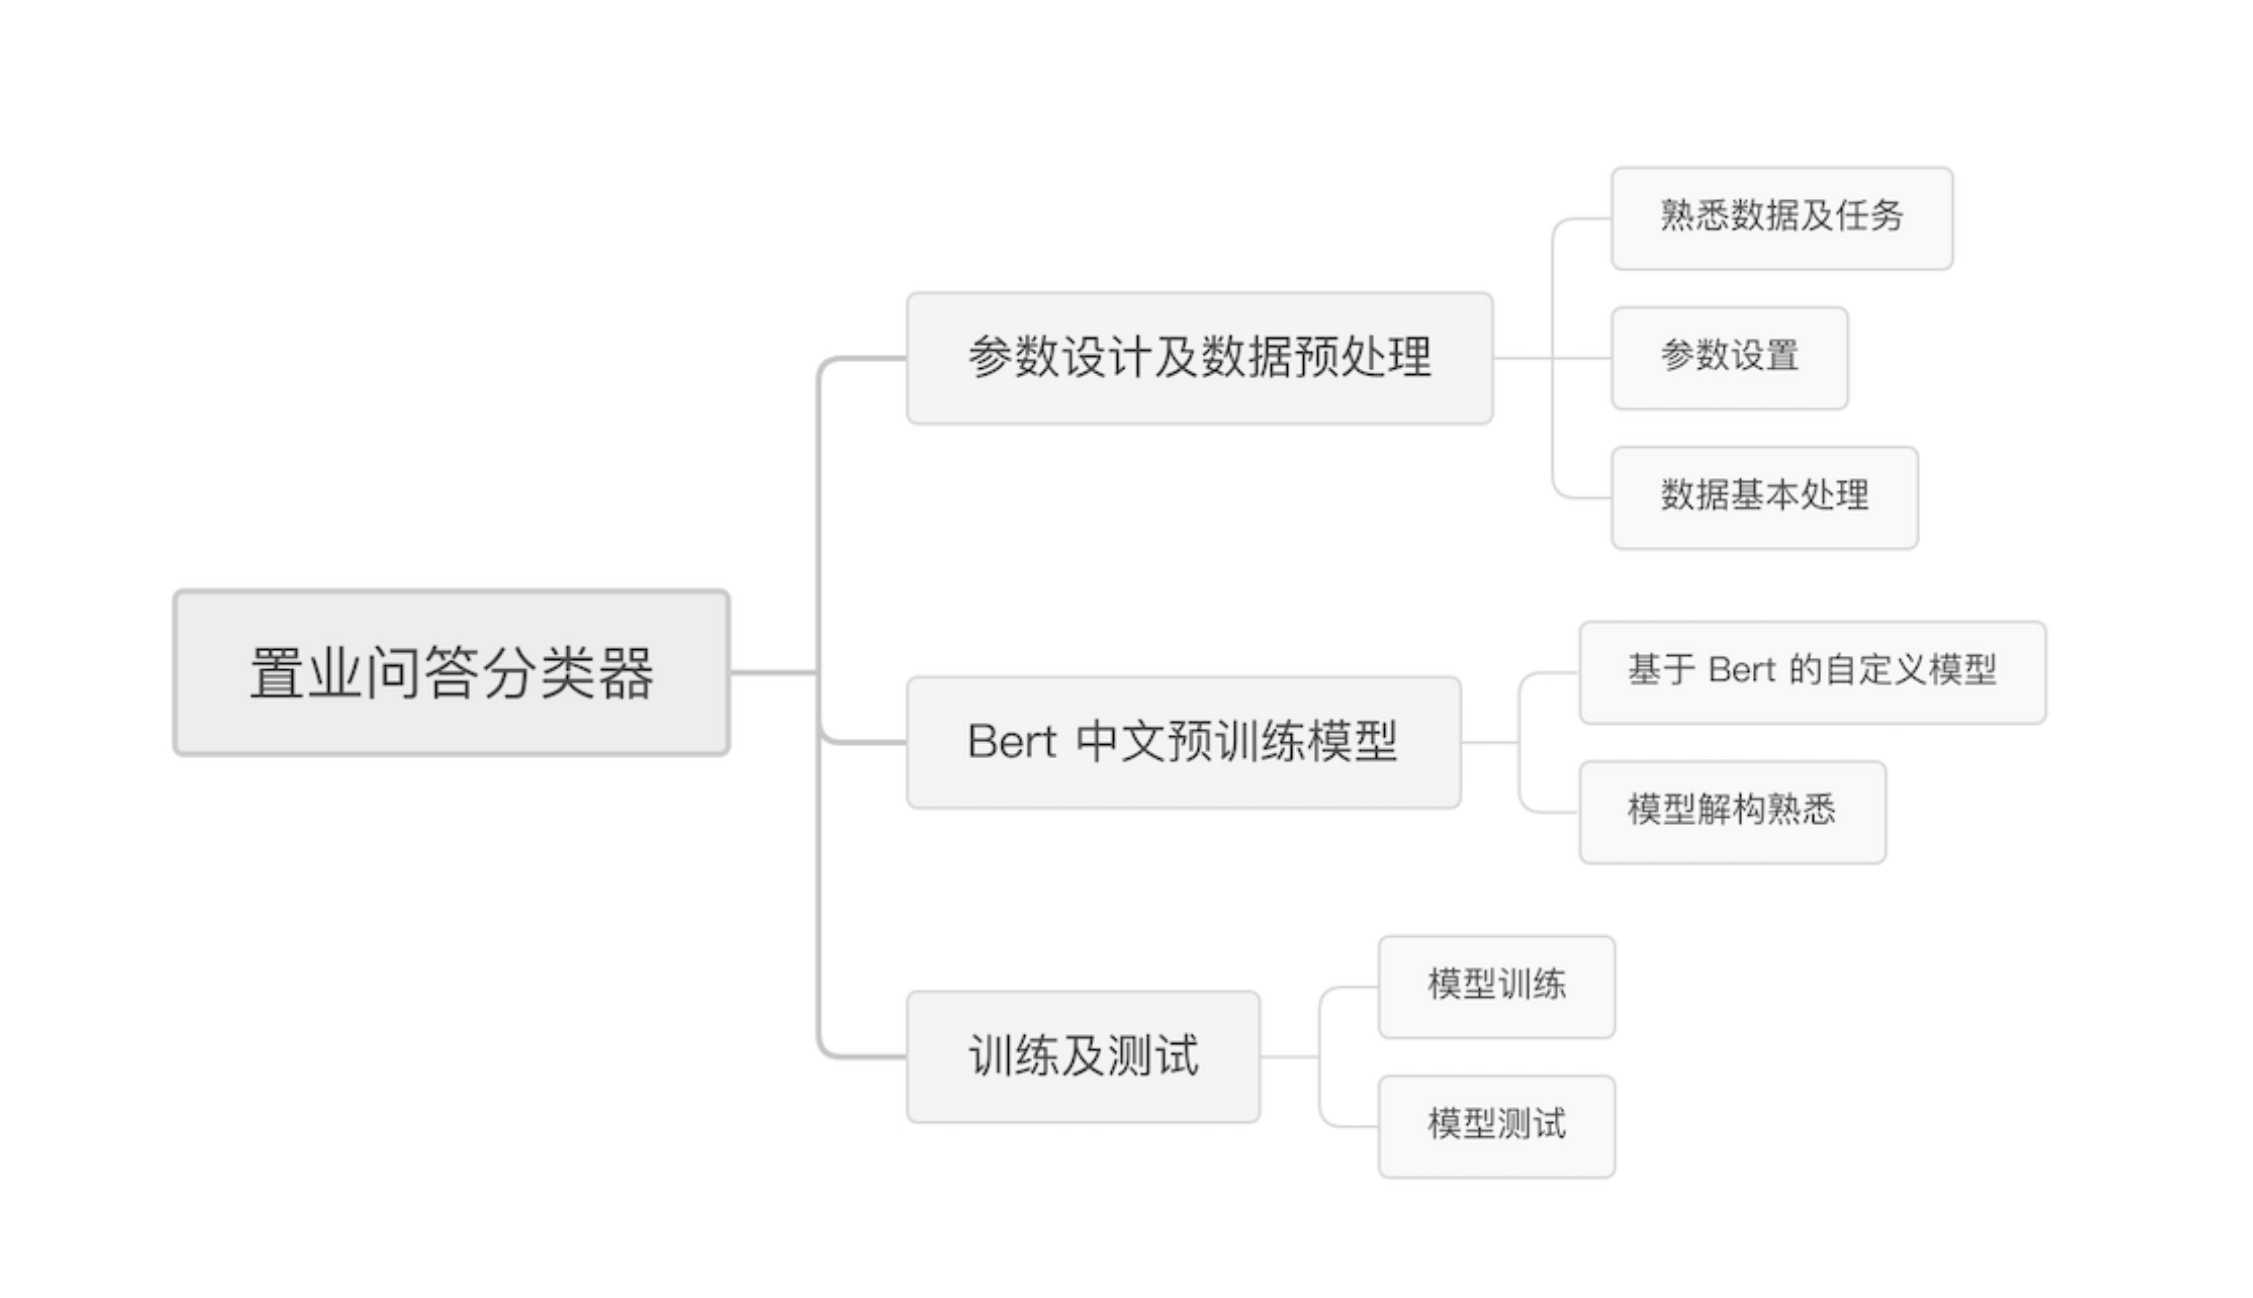

### 参数设计及数据预处理

此实验中的数据为置业顾问与潜在顾客间的问答，首先熟悉新闻数据，格式为 “问句\t回答\t标签”，如下例所示：

- 首付多少	首套房	1
- 首付多少	首付办完 63万左右	1
- 首付多少	包含全部	0
- 价格最低多少卖？	没有说，但是估计少不到多少	1
- 价格最低多少卖？	3楼房子卖了	0
- 采光怎么样呢？	今天有时间吗	0
- 采光怎么样呢？	我拿好钥匙可以直接现场看的	0
- 采光怎么样呢？	好的 就考虑义堂这块小三室吗	0

此任务目标在于判断输入的一问一答是否是真正的问答对，1 表示是，0 表示否。由于 Bert 模型在预训练过程中本身会输入两个句子，判断是否为<font color=#0099ff>上下文关系</font>，与当前任务目标一致，因此本项目可直接应用 Bert 预训练模型来进行微调。

由于本项目涉及到的参数较多，这里将所有参数整合到类 `Config` 中，主要涉及数据及模型相关的参数：

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
import torch
!pip install pytorch_transformers
from pytorch_transformers import BertModel, BertTokenizer


class Config(object):
    """配置参数"""

    def __init__(self, dataset):  # dataset指数据所在的文件名
        self.model_name = 'bert'
        self.train_path = dataset + '/train.txt'                                # 训练集
        self.dev_path = dataset + '/valid.txt'                                  # 验证集
        self.test_path = dataset + '/test.txt'                                  # 测试集
        self.save_path = dataset + self.model_name + '.pkl'        # 模型训练结果存储路径
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')   # 设备

        # 若超过 1000 batch 效果还没提升，则提前结束训练
        self.require_improvement = 1000
        self.class_list = [x.strip() for x in open(
            dataset + '/class.txt').readlines()]                       # 类别名单
        self.num_classes = len(self.class_list)                        # 类别数
        self.n_epochs = 1                                              # epoch 数
        self.batch_size = 38                                            # 一个 batch 的大小
        # 每句话处理成的长度(短填长切)
        self.pad_size = 20
        self.learning_rate = 5e-5                                       # 学习率
        self.bert_path = 'bert_wwm_pretrain'                            # 中文 Bert 预训练模型路径
        self.tokenizer = BertTokenizer.from_pretrained(
            self.bert_path)  # 预训练模型的 tokenizer
        self.hidden_size = 768      # 隐层大小

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

初始化参数类：

In [1]:
# 下载并解压数据集
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/BeiKeData.zip"
!unzip "BeiKeData.zip"
# 下载并解压预训练模型
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/bert_wwm_pretrain.zip"
!unzip "bert_wwm_pretrain.zip"
# 初始化参数类
config = Config("BeiKeData")

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


NameError: name 'Config' is not defined

接下来为 Bert 模型准备输入数据，首先需要设置一些特殊符号（这是 Bert 在预训练过程中数据本身带有的符号）：

In [ ]:
# 分别为 padding 符号, bert 中分类标志符号以及句子隔开符号
PAD, CLS, SEP = '[PAD]', '[CLS]', '[SEP]'

对于输入　Bert　的一对数据（一问一答）而言，需要转化为三种输入数据，首先假设数据对为：

- 问句 1：首付多少  
- 答句 2：首付办完63万左右

三大输入数据：

- input_ids（文本 id 向量）：添加标志符号,分词，并且截长补短（假设每个句子 pad_size = 5）：'[CLS] 首付　多少　[PAD] [SEP] 首付　办完　63　万　左右　[PAD] [SEP]'，接着将文本中的单词转化为对应的 id。
- attention_mask（文本 mask 向量）：由于 bert 模型会对 padding 的地方不进行 self-attention 处理，因此模型在输入中也要求需要输入一个相关向量，其表现形式为，mask 的地方对应为 0，其它地方为 1。当前例子对应的向量为，[1, 1, 1, ０, 1, １, 1, 1, 1, 1, 1, ０]。
- token_type_ids（文本类型向量）：生成句子类型相关的 id，第一个句子中的单词对应的 id 为 0（包括第一个 [SEP]），第二个的为 1。当前例子对应的向量为，[0, 0, 0, 0, 0, １, １, 1, 1, 1, 1, 1]。

为了实现以上转换，首先设计函数 `sen2id()`，能够将一个句子转换为 id，截长补短，并且对 padding 的地方进行 mask 处理，输出 token_ids, mask:

In [ ]:
def sen2id(sen):
    token = config.tokenizer.tokenize(sen)  # 分词
    token_ids = config.tokenizer.convert_tokens_to_ids(token)  # 转换为 id
    mask = []
    if config.pad_size:  # 截长补短
        if len(token) < config.pad_size:
            token_ids += ([0] * (config.pad_size - len(token)))
            mask = [1] * len(token) + [0] * (config.pad_size -
                                             len(token))  # mask 的地方对应为 0，其它地方为 1
        else:
            token_ids = token_ids[:config.pad_size]
            mask = [1] * config.pad_size
    return token_ids, mask

下一步整合两个句子的 token_ids, mask 作为 bert 的最终输入：

In [ ]:
def id2final_input(sen1_token_ids, sen2_token_ids, sen1_mask, sen2_mask):
    # 结合两个句子、三个标志符对应的 id
    input_ids = config.tokenizer.convert_tokens_to_ids(config.tokenizer.tokenize(CLS)) + sen1_token_ids + \
        config.tokenizer.convert_tokens_to_ids(config.tokenizer.tokenize(SEP)) + sen2_token_ids + \
        config.tokenizer.convert_tokens_to_ids(config.tokenizer.tokenize(SEP))
    token_type_ids = [0] * (config.pad_size + 2) + [1] * \
        (config.pad_size + 1)  # 句子类型对应的 向量
    attention_mask = [1] + sen1_mask + [1] + \
        sen2_mask + [1]  # 结合两个句子、三个标志符对应的 mask

    return input_ids, token_type_ids, attention_mask

综合以上处理过程加载训练集、验证集及测试集：

In [ ]:
from tqdm import tqdm  # 可视化加载进程


def load_dataset(path):
    contents = []  # 用于保存所有数据
    with open(path, 'r', encoding='UTF-8') as f:
        for line in tqdm(f):
            line = line.strip()
            if not line:  # 空行不作处理
                continue
            # 句子形式为 "句 1 \t 句 2 \t label"，所以用 \t 进行切分
            sen1, sen2, label = line.split('\t')
            # 分别获取每个句子的 token_ids, mask
            sen1_token_ids, sen1_mask = sen2id(sen1)
            sen2_token_ids, sen2_mask = sen2id(sen2)
            # 综合输出
            input_ids, token_type_ids, attention_mask = id2final_input(
                sen1_token_ids, sen2_token_ids, sen1_mask, sen2_mask)
            contents.append(
                (input_ids, int(label), token_type_ids, attention_mask))
    return contents

加载数据：

In [ ]:
# 加载训练、验证、测试集
traindata = load_dataset(config.train_path)
validdata = load_dataset(config.dev_path)
testdata = load_dataset(config.test_path)

一条数据最终的输入形式如下：

In [ ]:
for i in traindata[0]:  # 四元组（文本分词后的 id，标签，文本长度（不包括 padding ），mask）
    print(i)

下一步为设计数据迭代器，批次化地输出数据，注意 ` _to_tensor()` 涉及的输入变量有三大类：

In [ ]:
import math

# 数据迭代器


class DatasetIterator:
    def __init__(self, dataset, config):
        self.batch_size = config.batch_size  # 一批数据量的大小
        self.device = config.device
        self.dataset = dataset
        self.n_batches = math.floor(
            len(dataset)/config.batch_size)  # 向下取整的批次大小
        self.num = len(dataset)  # 数据量大小
        self.residue = True  # 默认不可以取整
        if len(dataset) % self.batch_size == 0:  # 所有数据量是否能被批数据量整除
            self.residue = False
        self.index = 0

    def _to_tensor(self, datas):  # 将数据转换为 tensor，并且 copy 一份到 device 所指定的环境上
        x = torch.LongTensor([_[0] for _ in datas]).to(self.device)  # 文本 id 向量
        y = torch.LongTensor([_[1] for _ in datas]).to(self.device)  # 标签
        type_ids = torch.LongTensor(
            [_[2] for _ in datas]).to(self.device)  # 文本类型向量
        mask = torch.LongTensor([_[3] for _ in datas]).to(
            self.device)  # 文本 mask 向量
        return (x, type_ids, mask), y

    def __next__(self):  # 返回迭代器的下一个元素
        if self.residue and self.index == self.n_batches:  # 在不能取整的情况下，对于最后一批数据，需要额外分为一种情况
            batch_data = self.dataset[self.index *
                                      self.batch_size:len(self.dataset)]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data  # 返回一个 batch 的数据
        elif self.index >= self.n_batches:  # 当 index 超出范围时，停止迭代
            self.index = 0
            raise StopIteration
        else:  # 其它情况
            batch_data = self.dataset[self.index *
                                      self.batch_size:(self.index+1)*self.batch_size]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data

    def __iter__(self):
        return self

    def __len__(self):  # 迭代器长度
        if self.residue:  # 如果不能取整，迭代器中的元素为向下取整的值 +1
            return self.n_batches + 1
        else:
            return self.n_batches

将三个数据集放入数据迭代器：

In [ ]:
# 数据迭代器
train_iter = DatasetIterator(traindata, config)
valid_iter = DatasetIterator(validdata, config)
test_iter = DatasetIterator(testdata, config)

### Bert 中文预训练模型

基于预训练中文模型 Bert，在其后加全连接层，映射至二维输出，设计一个问答二分类模型。

In [ ]:
import torch.nn as nn

# 模型


class WWMBert(nn.Module):
    def __init__(self, config):
        super(WWMBert, self).__init__()
        self.bert = BertModel.from_pretrained(
            config.bert_path)  # 获取 Bert 预训练模型
        for param in self.bert.parameters():  # Bert 预训练模型中的参数随着训练进行微调
            param.requires_grad = True
        self.fc = nn.Linear(config.hidden_size, config.num_classes)  # 最后添加全边接层

    def forward(self, x):
        context = x[0]  # 文本 id 向量
        type_ids = x[1]  # 句子类型向量
        mask = x[2]  # 文本 mask 向量
        _, pooled = self.bert(
            context, token_type_ids=type_ids, attention_mask=mask)
        out = self.fc(pooled)  # 最后输出
        return out

可知，定义模型的方式与其它实验中的方法无二致，基于 `BertModel.from_pretrained(config.bert_path)` 便可以引入 Bert 预训练模型，事实上直接可以把它当作你的模型中的一个<font color=#0099ff>比较巨大的 layer </font>而已。在其后再添加什么样的操作，只需要增加不同的 layer 即可，比如 Linear, LSTM, CNN 等，均可尝试。

查看模型：

可知，Bert 模型由 BertEmbeddings, BertEncoder(12 层 BertLayer), BertOutput 以及 BertPooler  构成。其中的主要成分 BertLayer 便是基于自注意力机制的结构。

### 训练及测试

最后一部分主要涉及模型的训练及测试，训练过程与其它一般项目类似。特别地，对模型中的参数进行正则化，除却偏置参数。

In [ ]:
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert.optimization import BertAdam

criterion = nn.CrossEntropyLoss()


def train(model, data_iter, config):
    model.train()
    train_loss = 0
    # 设置被正则化的参数
    param_optimizer = list(model.named_parameters())
    # weight decay 是放在正则项（regularization）前面的一个系数,用于调节正则化的强度
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']  # 此类参数不进行正则化
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(
            nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # 优化器
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=config.learning_rate,
                         warmup=0.05,  # 预热阶段
                         t_total=data_iter.num * config.n_epochs)  # 迭代次数

    for data, labels in data_iter:
        model.zero_grad()
        output = model(data)  # 模型输出
        loss = criterion(output, labels)  # 计算损失
        loss.backward()  # 损失回传
        optimizer.step()
        train_loss += loss.item()  # 损失叠加

    return train_loss / data_iter.num

接下来设计的函数用于验证或测试过程，特别地，在测试模式中，输出更多的性能计算结果：

In [ ]:
from sklearn import metrics


def test(model, data_iter, config, test_mode=True):  # 分为验证与测试两种模式
    model.eval()
    test_loss = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    with torch.no_grad():
        for texts, labels in data_iter:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)
    acc = metrics.accuracy_score(labels_all, predict_all)

    if test_mode:  # 如果为测试模式，更多的性能计算
        report = metrics.classification_report(
            labels_all, predict_all, target_names=config.class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, test_loss / data_iter.num, report, confusion
    return acc, test_loss / data_iter.num

在定义好了训练及测试函数后，在最后部分进行模型训练及验证。首先设置随机种子：

In [ ]:
import numpy as np

# 保证每次结果一样
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

训练开始：

In [ ]:
import time

best_valid_loss = float('inf')
# 开始训练
for epoch in range(config.n_epochs):
    start_time = time.time()  # 计时

    train_loss = train(bert_model, train_iter, config)
    valid_acc, valid_loss = test(
        bert_model, valid_iter, config, test_mode=False)

    if valid_loss < best_valid_loss:  # 保存最好的模型
        best_valid_loss = valid_loss
        torch.save(bert_model.state_dict(), 'beike_classifier_cpu.pkl')

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    # 训练过程可视化
    print('Epoch: %d' % (epoch + 1),
          " | %d minutes, %d seconds" % (mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)')
    print(
        f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

应用训练好的模型对测试集进行预测：

In [ ]:
# 记录时长
start_time = time.time()
print('测试结果：')
test_model = WWMBert(config).to(config.device)
# 加载模型
test_model.load_state_dict(torch.load("beike_classifier_cpu.pkl"))

由于在线环境运行较慢，上面只训练了 1 个 EPOCH 作为演示。接下来，你可以下载我在本地训练了 30 个 EPOCH 的模型用于推理：

```python
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/beike_classifier.pkl.zip"
!unzip -o beike_classifier.pkl.zip
test_model.load_state_dict(torch.load("beike_classifier.pkl",map_location=torch.device('cpu')))
```

进行测试:

In [ ]:
test_acc, test_loss, test_report, test_confusion = test(
    test_model, test_iter, config, test_mode=True)

打印测试结果:

In [ ]:
secs = int(time.time() - start_time)
mins = secs / 60
secs = secs % 60
print('time in %d minutes, %d seconds' % (mins, secs))

msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
print(msg.format(test_loss, test_acc))
print("Precision, Recall and F1-Score...")
print(test_report)
print("Confusion Matrix...")
print(test_confusion)

对于二分类任务以及当前的训练数据量而言，以上的实验结果其实并不如意，同学们可以在此基础上从不同的方面尝试优化，例如数据预处理、参数调节、替换预训练模型、在预训练模型后接不一样的结构等。

### 实验总结

本实验本身的任务并不难，同学们在这里主要需要学会的是，如何利用预训练模型以及添加自定义层，应用于下游任务。当然，学有余力的还可以进行一些更高级的操作，比如应用下游无标注数据对预训练模型进行再预训练、基于不同特性的任务获取预训练模型中的特定层进行编码、对预训练的不同层输出做一些特殊操作、对庞大的预训练模型进行蒸馏等。

本实验的主要知识点如下：

- 参数设计及数据预处理
- Bert 中文预训练模型
- 训练及测试